In [1]:
!pip install tensorflow matplotlib

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.data import AUTOTUNE
import matplotlib.pyplot as plt
import os
import numpy as np


2025-11-04 18:04:24.436783: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-04 18:04:24.661867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-04 18:04:26.796846: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:

# ---------------------------------
# 1. КОНФІГУРАЦІЯ
# ---------------------------------
print("--- Етап 1: Конфігурація ---")

# Шляхи до даних
DATA_DIR = './learning/data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Параметри моделі
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 128      # 128 або 256 - хороший вибір для великих сетів
COLOR_MODE = 'grayscale'
CHANNELS = 1
NUM_CLASSES = 11    # Дуже важливо! 0-9 плюс клас 10 (сміття)
EPOCHS = 10         # 10 епох для початку. Може знадобитися більше.


--- Етап 1: Конфігурація ---


In [4]:

# ---------------------------------
# 2. ЗАВАНТАЖЕННЯ ДАНИХ (ЕФЕКТИВНО)
# ---------------------------------
print("--- Етап 2: Завантаження даних ---")

# Keras утиліта для завантаження даних з папок
# Вона автоматично знайде класи (0, 1, 2... 10)
# label_mode='categorical' автоматично перетворить ярлики у one-hot
# [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

print("Завантаження TRAIN датасету...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical', # <--- Важливо для categorical_crossentropy
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

print("\nЗавантаження TEST (Validation) датасету...")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    label_mode='categorical',
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False # Перемішування не потрібне для тестування
)

# Отримуємо імена класів (має бути ['0', '1', '10', '2', ...])
class_names = train_dataset.class_names
print(f"\nЗнайдено класи: {class_names}")
if len(class_names) != NUM_CLASSES:
    print(f"ПОМИЛКА: Очікувалось {NUM_CLASSES} класів, але знайдено {len(class_names)}")
    # Тут можна зупинити блокнот


--- Етап 2: Завантаження даних ---
Завантаження TRAIN датасету...
Found 284200 files belonging to 11 classes.


I0000 00:00:1762279510.389478    9725 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3554 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9



Завантаження TEST (Validation) датасету...
Found 10100 files belonging to 11 classes.

Знайдено класи: ['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


In [5]:

# ---------------------------------
# 3. ОПТИМІЗАЦІЯ ПАЙПЛАЙНУ ДАНИХ
# ---------------------------------
print("\n--- Етап 3: Оптимізація пайплайну ---")

# .cache() - кешує дані в пам'ять після першого читання
# .prefetch() - готує наступні батчі, поки GPU тренується
# Це КРИТИЧНО для швидкості тренування

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Пайплайни даних готові.")



--- Етап 3: Оптимізація пайплайну ---
Пайплайни даних готові.


In [6]:
print("\n--- Етап 4: Побудова архітектури (v2.0 з регуляризацією) ---")


# Вхідний шар
inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS))

# 1. Нормалізація
x = layers.Rescaling(1./255)(inputs)

# === Блок 1 ===
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x) # <--- ДОДАНО
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x) # <--- ДОДАНО

# === Блок 2 ===
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x) # <--- ДОДАНО
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x) # <--- ДОДАНО

# === Блок 3 ===
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x) # <--- ДОДАНО
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x) # <--- ДОДАНО

# === Голова класифікатора ===
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x) # <--- ДОДАНО
x = layers.Dropout(0.5)(x) # <--- Старий шар, залишаємо

# === Вихідний шар ===
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Збираємо модель
model = keras.Model(inputs=inputs, outputs=outputs)


--- Етап 4: Побудова архітектури (v2.0 з регуляризацією) ---


In [7]:
print("\n--- Етап 5: Компіляція моделі (v2.0) ---")

# Ідея №3: Зменшуємо швидкість навчання
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005) # Було 0.001 (default)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Виведемо структуру моделі
model.summary()


--- Етап 5: Компіляція моделі (v2.0) ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,144,203 (4.36 MB)

 Trainable params: 1,143,499 (4.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [8]:
# 6. НАВЧАННЯ МОДЕЛІ
# ---------------------------------
print("\n--- Етап 6: Початок навчання ---")
print(f"Тренування на {EPOCHS} епох...")

# Створюємо колбек для збереження ТІЛЬКИ найкращої моделі
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='../models/digit_classifier_best.keras', # Збережемо в папку models
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

# Запускаємо процес навчання
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=[model_checkpoint] # Додаємо колбек
)

print("\n--- Навчання завершено! ---")



--- Етап 6: Початок навчання ---
Тренування на 10 епох...
Epoch 1/10


2025-11-04 18:05:16.303687: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fadbc01cea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-04 18:05:16.303723: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-11-04 18:05:16.422854: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-04 18:05:16.891970: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


   2/2221 ━━━━━━━━━━━━━━━━━━━━ 1:59 54ms/step - accuracy: 0.0762 - loss: 3.5595  

I0000 00:00:1762279524.635358    9828 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2220/2221 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7928 - loss: 0.6846

2025-11-04 18:07:20.905003: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-04 18:07:21.179694: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2543', 8 bytes spill stores, 8 bytes spill loads

2025-11-04 18:07:21.717586: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2934', 136 bytes spill stores, 136 bytes spill loads

2025-11-04 18:07:21.806710: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2934', 520 b

2221/2221 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7928 - loss: 0.6844

2025-11-04 18:07:30.796219: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_217', 8 bytes spill stores, 8 bytes spill loads

2025-11-04 18:07:31.014260: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_206', 24 bytes spill stores, 24 bytes spill loads



2221/2221 ━━━━━━━━━━━━━━━━━━━━ 138s 57ms/step - accuracy: 0.9094 - loss: 0.2983 - val_accuracy: 0.8887 - val_loss: 0.6180
Epoch 2/10
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.9803 - loss: 0.0646 - val_accuracy: 0.8908 - val_loss: 0.6523
Epoch 3/10
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 53s 24ms/step - accuracy: 0.9865 - loss: 0.0436 - val_accuracy: 0.9031 - val_loss: 0.6334
Epoch 4/10
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - accuracy: 0.9893 - loss: 0.0343 - val_accuracy: 0.8991 - val_loss: 0.6945
Epoch 5/10
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 52s 23ms/step - accuracy: 0.9909 - loss: 0.0287 - val_accuracy: 0.9020 - val_loss: 0.7253
Epoch 6/10
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - accuracy: 0.9925 - loss: 0.0245 - val_accuracy: 0.9133 - val_loss: 0.6195
Epoch 7/10
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 53s 24ms/step - accuracy: 0.9928 - loss: 0.0227 - val_accuracy: 0.9159 - val_loss: 0.6320
Epoch 8/10
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 52s 23ms/step - accuracy: 0.9935 - loss: 0.0

In [9]:

# ---------------------------------
# 7. ОЦІНКА ТА ЗБЕРЕЖЕННЯ
# ---------------------------------
print("\n--- Етап 7: Оцінка та збереження ---")

# Оцінка на тестовому наборі (дасть ті ж цифри, що й остання епоха)
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nФінальна точність на тестовому наборі: {test_acc*100:.2f}%")

# Збереження фінальної моделі (не обов'язково найкращої)
model.save('../models/digit_classifier_final.keras')
print(f"Фінальну модель збережено в ../models/digit_classifier_final.keras")
print(f"Найкращу модель збережено в ../models/digit_classifier_best.keras")



--- Етап 7: Оцінка та збереження ---
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9156 - loss: 0.6385

Фінальна точність на тестовому наборі: 91.56%
Фінальну модель збережено в ../models/digit_classifier_final.keras
Найкращу модель збережено в ../models/digit_classifier_best.keras



--- Етап 8: Візуалізація результатів ---
Графіки навчання збережено в ../models/training_history.png


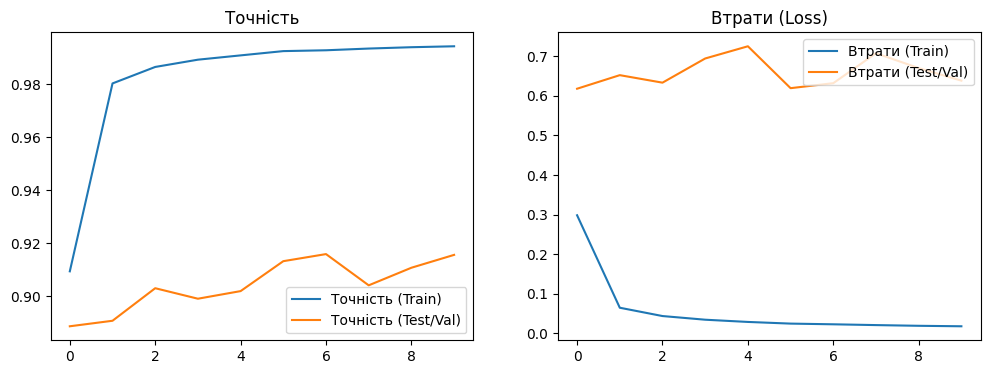

In [10]:

# ---------------------------------
# 8. ВІЗУАЛІЗАЦІЯ РЕЗУЛЬТАТІВ
# ---------------------------------
print("\n--- Етап 8: Візуалізація результатів ---")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точність (Train)')
plt.plot(epochs_range, val_acc, label='Точність (Test/Val)')
plt.legend(loc='lower right')
plt.title('Точність')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Втрати (Train)')
plt.plot(epochs_range, val_loss, label='Втрати (Test/Val)')
plt.legend(loc='upper right')
plt.title('Втрати (Loss)')

plt.savefig('../models/training_history.png')
print("Графіки навчання збережено в ../models/training_history.png")
plt.show()